In [1]:
import qrcode
from PIL import Image
class QrCodeGenerator():
    def __init__(self):
        self.qr = qrcode.QRCode(
            version = 1,
            error_correction = qrcode.constants.ERROR_CORRECT_H,
            box_size = 16,
            border = 0,
        )
    def generator_qr_code(self, qrcode_content: str):
        self.qr.add_data(qrcode_content)
        self.qr.make(fit = True)

        img = self.qr.make_image(fill_color = "black", back_color="white")
        return img.get_image()
    def add_offset_background(self, img: Image, offset_min: int = 0):
        w, h = img.size
        w = w + 255 + offset_min
        h = h + 255 + offset_min

        if w > 1024:
            raise ValueError("QR Code is too big, please regenerate a shorter URL")
        bg_img = Image.new('L', (w,h), 255)
        coords = ((w-img.size[0]) // 2 // 16*16,
                (h-img.size[1]) // 2 // 16*16)
        bg_img.paste(img, coords)
        return bg_img
    

In [2]:
qrcode_gen = QrCodeGenerator()
qrcode_img = qrcode_gen.generator_qr_code("https://www.youtube.com/")
bg_qrcode_img = qrcode_gen.add_offset_background(qrcode_img)

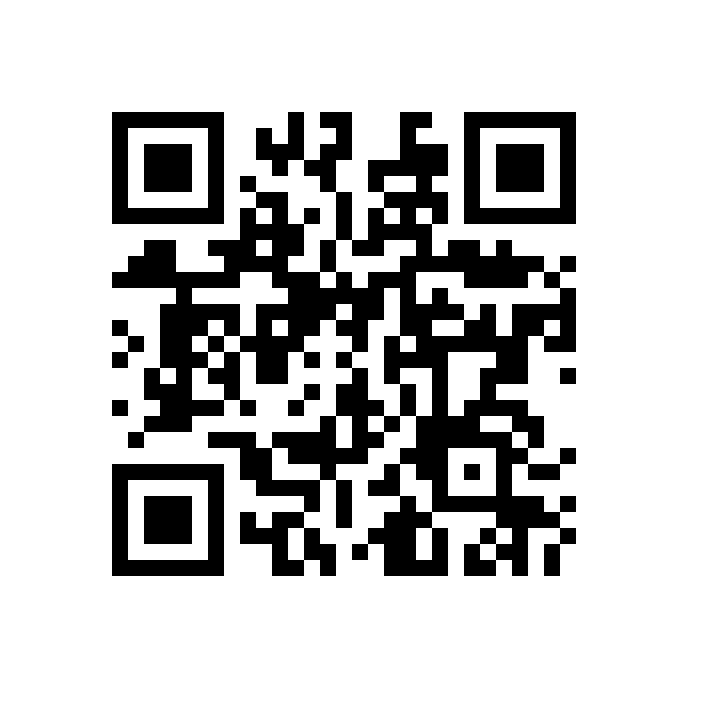

In [3]:
bg_qrcode_img

# QR CODE conditioned controlnet models for stable diffusion 1.5 (diffusers)

In [4]:
import torch
from diffusers import ControlNetModel, StableDiffusionControlNetImg2ImgPipeline, DDIMScheduler

controlnet = ControlNetModel.from_pretrained("DionTimmer/controlnet_qrcode-control_v1p_sd15",
                                             torch_dtype=torch.float16)

/home/codespace/.python/current/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/codespace/.python/current/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [5]:
cn_pipeline = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [6]:
# cn_pipeline.enable_xformers_memory_efficient_attention() # only use this cmd for gpu
cn_pipeline.scheduler = DDIMScheduler.from_config(cn_pipeline.scheduler.config)
cn_pipeline.enable_model_cpu_offload()

In [7]:
IMG_WIDTH = 768
IMG_HEIGHT = 768
from typing import Tuple

def resize_for_input_image(input_image: Image, resolution: Tuple[int,int] = (IMG_WIDTH,IMG_HEIGHT)):
    input_image = input_image.convert("RGB")
    img = input_image.resize(resolution, resample = Image.LANCZOS)
    return img

# QR Code image
condition_image = resize_for_input_image(bg_qrcode_img)
# Init img can be anything
from diffusers.utils import load_image

init_image = load_image("/workspaces/codespaces-jupyter/Nyc.jpg")
init_image = resize_for_input_image(init_image)

In [8]:
condition_image.size, init_image.size

((768, 768), (768, 768))

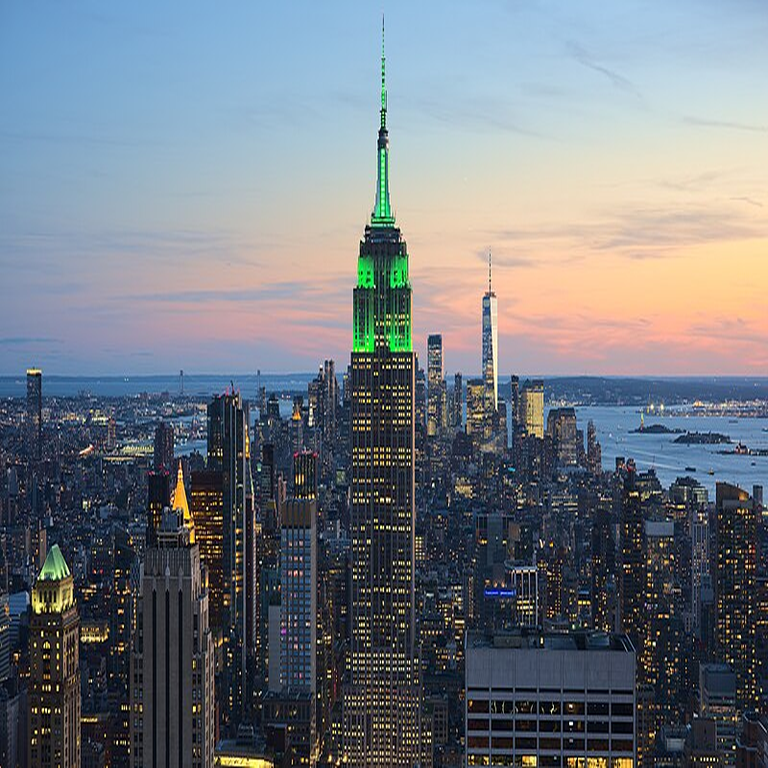

In [9]:
init_image

In [14]:
torch.set_default_tensor_type(torch.FloatTensor)

# Tiếp tục với đoạn mã của bạn
generator = torch.Generator()
output = cn_pipeline(
    prompt="a peaceful countryside in Vietnam",
    negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
    image=init_image,
    control_image=condition_image,
    width=IMG_WIDTH,
    height=IMG_HEIGHT,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.9,
    generator=generator,
    strength=1.0,
    num_inference_steps=20,
)
output.images[0]

No GPU available. Using CPU.


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx